<a href="https://colab.research.google.com/github/marcinwolter/DeepLearning_2020_private/blob/main/mnist_cnn_augmentation_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [377]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 99.6% test accuracy after 40 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import RMSprop, Adam, Adadelta

from keras.backend import clear_session

from keras.utils.vis_utils import plot_model
from IPython.display import Image 

from keras.callbacks import EarlyStopping

#augmentation
from keras.preprocessing.image import ImageDataGenerator

! pip install optuna
import optuna



batch_size = 128
num_classes = 10
epochs = 200

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train0, num_classes)
y_test = keras.utils.to_categorical(y_test0, num_classes)



60000 train samples
10000 test samples


# **Reduce the dataset size**

In [378]:
N_TRAIN_EXAMPLES = 1000 #3000
N_TEST_EXAMPLES = 10000

x_train = x_train[:N_TRAIN_EXAMPLES]
x_test = x_test[:N_TEST_EXAMPLES]
y_train = y_train[:N_TRAIN_EXAMPLES]
y_test = y_test[:N_TEST_EXAMPLES]

In [382]:
def create_model():

# Our old fully connected (dense) network
#model = Sequential()
#model.add(Dense(512, activation='relu', input_shape=(784,)))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(num_classes, activation='softmax'))

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))




  #model.summary()

  return model

In [383]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
#Image('model_plot.png')

In [384]:
def objective(trial):

  # Clear clutter from previous Keras session graphs.  
  clear_session()

  # CREATE MORE IMAGES VIA DATA AUGMENTATION
  rotation_range = trial.suggest_uniform('rotation_range', .00,30)
  zoom_range = trial.suggest_uniform('zoom_range', .00,0.30)
  shift_range = trial.suggest_uniform('shift_range', .00,0.20)
  
  datagen = ImageDataGenerator( 
        rotation_range=rotation_range,  
        zoom_range = zoom_range,   
        width_shift_range = shift_range,  
        height_shift_range = shift_range)
    
  model = create_model()  

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

  es = EarlyStopping(monitor = 'val_accuracy', patience = 12, verbose=1)
  history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                    callbacks = [es])
  
  score = model.evaluate(x_test, y_test, verbose=0)
  return score[1]

In [385]:
# Optimize using OPTUNA

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=30, timeout=1200)

[I 2020-12-14 14:35:24,207] A new study created in memory with name: no-name-3a14ffd4-ad87-4126-becc-93d72fb6e182


Epoch 00075: early stopping


[I 2020-12-14 14:36:01,204] Trial 0 finished with value: 0.9771000146865845 and parameters: {'rotation_range': 18.97563538451161, 'zoom_range': 0.1932743628198735, 'shift_range': 0.06211786614685131}. Best is trial 0 with value: 0.9771000146865845.


Epoch 00089: early stopping


[I 2020-12-14 14:36:44,695] Trial 1 finished with value: 0.9732999801635742 and parameters: {'rotation_range': 17.542907662717234, 'zoom_range': 0.009773803164709882, 'shift_range': 0.1697293377894405}. Best is trial 0 with value: 0.9771000146865845.


Epoch 00060: early stopping


[I 2020-12-14 14:37:14,336] Trial 2 finished with value: 0.9740999937057495 and parameters: {'rotation_range': 2.4668125209918235, 'zoom_range': 0.16140622134408944, 'shift_range': 0.09352597700672845}. Best is trial 0 with value: 0.9771000146865845.


Epoch 00089: early stopping


[I 2020-12-14 14:37:57,962] Trial 3 finished with value: 0.972599983215332 and parameters: {'rotation_range': 16.338303202402656, 'zoom_range': 0.04179389812132262, 'shift_range': 0.11555120287307048}. Best is trial 0 with value: 0.9771000146865845.


Epoch 00085: early stopping


[I 2020-12-14 14:38:39,851] Trial 4 finished with value: 0.9764000177383423 and parameters: {'rotation_range': 18.405801530043302, 'zoom_range': 0.15305165787955408, 'shift_range': 0.15342220997622202}. Best is trial 0 with value: 0.9771000146865845.


Epoch 00104: early stopping


[I 2020-12-14 14:39:30,611] Trial 5 finished with value: 0.9771999716758728 and parameters: {'rotation_range': 28.53736853729875, 'zoom_range': 0.15703860262864452, 'shift_range': 0.09844919723818109}. Best is trial 5 with value: 0.9771999716758728.


Epoch 00107: early stopping


[I 2020-12-14 14:40:23,157] Trial 6 finished with value: 0.9757999777793884 and parameters: {'rotation_range': 27.594809995948395, 'zoom_range': 0.18816674482689325, 'shift_range': 0.17355681302058837}. Best is trial 5 with value: 0.9771999716758728.


Epoch 00115: early stopping


[I 2020-12-14 14:41:19,299] Trial 7 finished with value: 0.9815999865531921 and parameters: {'rotation_range': 23.01995390615952, 'zoom_range': 0.19073341830652732, 'shift_range': 0.09341077502485418}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00105: early stopping


[I 2020-12-14 14:42:10,720] Trial 8 finished with value: 0.9807999730110168 and parameters: {'rotation_range': 2.5883290652283444, 'zoom_range': 0.28805981611482906, 'shift_range': 0.12301609409811827}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00053: early stopping


[I 2020-12-14 14:42:37,997] Trial 9 finished with value: 0.972000002861023 and parameters: {'rotation_range': 17.310054542185583, 'zoom_range': 0.16770197495809597, 'shift_range': 0.030497184475576835}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00077: early stopping


[I 2020-12-14 14:43:17,819] Trial 10 finished with value: 0.972000002861023 and parameters: {'rotation_range': 8.280843114430109, 'zoom_range': 0.2772813940001834, 'shift_range': 0.0055711268787632245}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00071: early stopping


[I 2020-12-14 14:43:53,959] Trial 11 finished with value: 0.9804999828338623 and parameters: {'rotation_range': 24.55958834926483, 'zoom_range': 0.27579958157797074, 'shift_range': 0.13291571457754878}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00078: early stopping


[I 2020-12-14 14:44:33,727] Trial 12 finished with value: 0.9800999760627747 and parameters: {'rotation_range': 0.009726041588387968, 'zoom_range': 0.23648819745703298, 'shift_range': 0.07324511366714823}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00052: early stopping


[I 2020-12-14 14:45:01,996] Trial 13 finished with value: 0.9717000126838684 and parameters: {'rotation_range': 9.562204311534774, 'zoom_range': 0.07232899869909444, 'shift_range': 0.05809934372653975}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00080: early stopping


[I 2020-12-14 14:45:42,310] Trial 14 finished with value: 0.9664000272750854 and parameters: {'rotation_range': 23.920676540108815, 'zoom_range': 0.09541790967642765, 'shift_range': 0.19899280692822968}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00093: early stopping


[I 2020-12-14 14:46:29,359] Trial 15 finished with value: 0.9688000082969666 and parameters: {'rotation_range': 11.64626763665352, 'zoom_range': 0.2334110639097933, 'shift_range': 0.13357348392682147}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00093: early stopping


[I 2020-12-14 14:47:16,634] Trial 16 finished with value: 0.9793999791145325 and parameters: {'rotation_range': 5.721264705589638, 'zoom_range': 0.22886505906441396, 'shift_range': 0.11905079023198945}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00072: early stopping


[I 2020-12-14 14:47:53,450] Trial 17 finished with value: 0.980400025844574 and parameters: {'rotation_range': 21.827409229803674, 'zoom_range': 0.2941778353568673, 'shift_range': 0.0848741940485894}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00108: early stopping


[I 2020-12-14 14:48:48,247] Trial 18 finished with value: 0.9793999791145325 and parameters: {'rotation_range': 11.596095051871233, 'zoom_range': 0.11704975187633068, 'shift_range': 0.04607946799804346}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00068: early stopping


[I 2020-12-14 14:49:22,731] Trial 19 finished with value: 0.9772999882698059 and parameters: {'rotation_range': 21.55519227075951, 'zoom_range': 0.2583959828541397, 'shift_range': 0.11606214190804101}. Best is trial 7 with value: 0.9815999865531921.


Epoch 00110: early stopping


[I 2020-12-14 14:50:17,872] Trial 20 finished with value: 0.9828000068664551 and parameters: {'rotation_range': 13.541053906184843, 'zoom_range': 0.20774149528894514, 'shift_range': 0.14908135240018783}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00087: early stopping


[I 2020-12-14 14:51:02,174] Trial 21 finished with value: 0.9707000255584717 and parameters: {'rotation_range': 13.741697545151686, 'zoom_range': 0.20344136363490875, 'shift_range': 0.15187058943909387}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00106: early stopping


[I 2020-12-14 14:51:55,819] Trial 22 finished with value: 0.9668999910354614 and parameters: {'rotation_range': 3.161383646957246, 'zoom_range': 0.21620160574585826, 'shift_range': 0.18571167715312886}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00069: early stopping


[I 2020-12-14 14:52:31,297] Trial 23 finished with value: 0.9732000231742859 and parameters: {'rotation_range': 14.04724970926921, 'zoom_range': 0.13370799560950886, 'shift_range': 0.1458302159826614}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00068: early stopping


[I 2020-12-14 14:53:06,067] Trial 24 finished with value: 0.9764999747276306 and parameters: {'rotation_range': 25.907145062067983, 'zoom_range': 0.2541895639322026, 'shift_range': 0.10859126254805983}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00069: early stopping


[I 2020-12-14 14:53:41,837] Trial 25 finished with value: 0.9743000268936157 and parameters: {'rotation_range': 29.93427557837898, 'zoom_range': 0.29669611645237015, 'shift_range': 0.1317301878326011}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00089: early stopping


[I 2020-12-14 14:54:26,470] Trial 26 finished with value: 0.9779999852180481 and parameters: {'rotation_range': 5.285426557220162, 'zoom_range': 0.19057982338798735, 'shift_range': 0.08198976081586605}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00060: early stopping


[I 2020-12-14 14:54:57,016] Trial 27 finished with value: 0.9692999720573425 and parameters: {'rotation_range': 0.29186084934925116, 'zoom_range': 0.17576734939682073, 'shift_range': 0.16497224382921816}. Best is trial 20 with value: 0.9828000068664551.


Epoch 00070: early stopping


[I 2020-12-14 14:55:32,464] Trial 28 finished with value: 0.9764999747276306 and parameters: {'rotation_range': 21.361137198844162, 'zoom_range': 0.2552406253111131, 'shift_range': 0.10309455156428371}. Best is trial 20 with value: 0.9828000068664551.


In [386]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 29
Best trial:
  Value: 0.9828000068664551
  Params: 
    rotation_range: 13.541053906184843
    zoom_range: 0.20774149528894514
    shift_range: 0.14908135240018783


# **Train with optimized parameters**

In [387]:

# Clear clutter from previous Keras session graphs.
clear_session()


# CREATE MORE IMAGES VIA DATA AUGMENTATION
#  rotation_range = trial.suggest_uniform('rotation_range', .00,30)
#  zoom_range = trial.suggest_uniform('zoom_range', .00,0.30)
#  shift_range = trial.suggest_uniform('shift_range', .00,0.20)

rotation_range = trial.params.get('rotation_range')
zoom_range = trial.params.get('zoom_range')
shift_range = trial.params.get('shift_range')

datagen = ImageDataGenerator( 
        rotation_range=rotation_range,  
        zoom_range = zoom_range,   
        width_shift_range = shift_range,  
        height_shift_range = shift_range)
    
    
model = create_model()  

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_accuracy', patience = 12, verbose=1)
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks = [es])


Epoch 1/200
8/8 [==============================] - 1s 82ms/step - loss: 2.2981 - accuracy: 0.1150 - val_loss: 2.2540 - val_accuracy: 0.1297
Epoch 2/200
8/8 [==============================] - 1s 64ms/step - loss: 2.2604 - accuracy: 0.1810 - val_loss: 2.0699 - val_accuracy: 0.4463
Epoch 3/200
8/8 [==============================] - 1s 64ms/step - loss: 2.1212 - accuracy: 0.2610 - val_loss: 1.5000 - val_accuracy: 0.6419
Epoch 4/200
8/8 [==============================] - 1s 64ms/step - loss: 1.9591 - accuracy: 0.3310 - val_loss: 1.3827 - val_accuracy: 0.7538
Epoch 5/200
8/8 [==============================] - 1s 64ms/step - loss: 1.7173 - accuracy: 0.4100 - val_loss: 0.7990 - val_accuracy: 0.7755
Epoch 6/200
8/8 [==============================] - 1s 63ms/step - loss: 1.5255 - accuracy: 0.4730 - val_loss: 0.7243 - val_accuracy: 0.8143
Epoch 7/200
8/8 [==============================] - 1s 64ms/step - loss: 1.4003 - accuracy: 0.5300 - val_loss: 0.5594 - val_accuracy: 0.8731
Epoch 8/200
8/8 [===

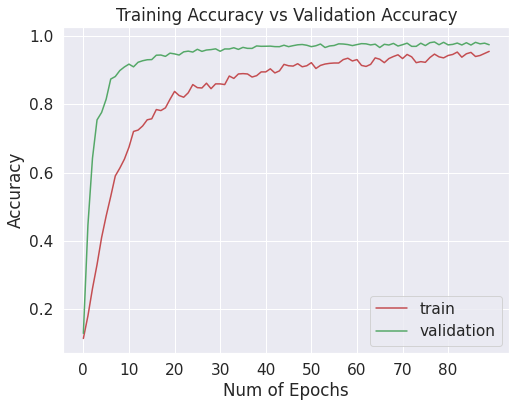

In [388]:
# Plots for training and testing process: loss and accuracy

n_epochs = len(history.history['loss'])

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])




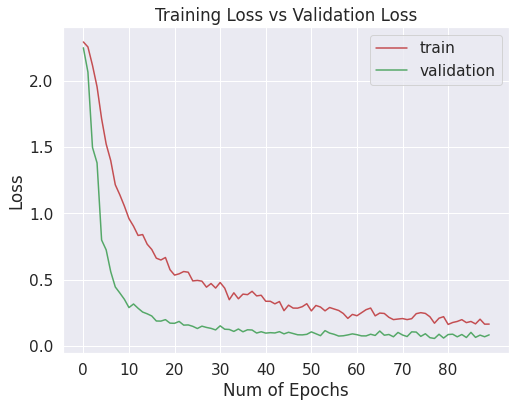

In [389]:
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, n_epochs, 10.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()


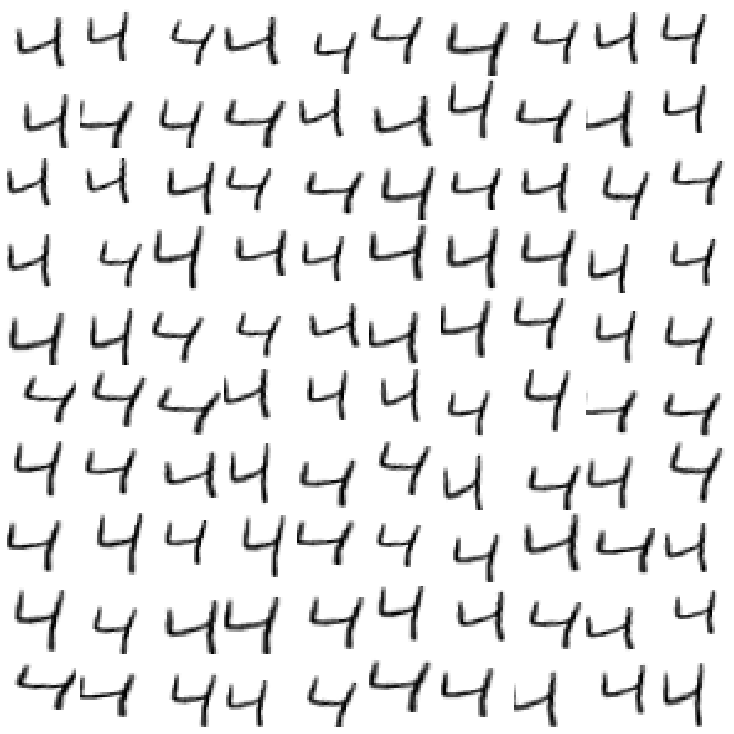

In [404]:
# see augmentation example (single digit)
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(0, 100):
    for X_train, Y_train in datagen.flow(x_train[2:3], y_train[2:3], batch_size=1, shuffle=False):
         plt.subplot(10,10,i+1)
         plt.imshow(X_train[0].reshape((img_rows, img_cols)), cmap=plt.cm.binary, interpolation='nearest')
         plt.axis('off')
         break

plt.show()

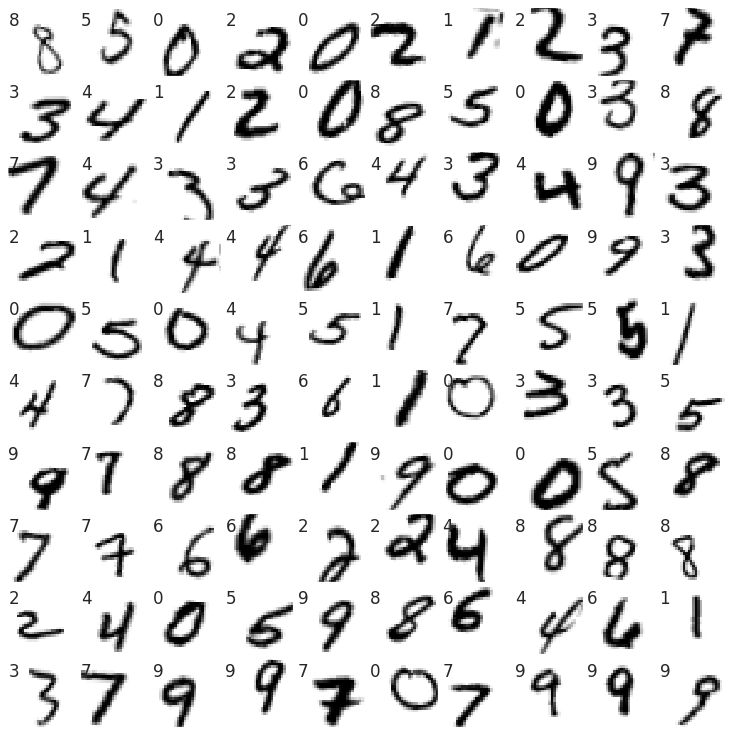

In [405]:
#visualize the digits

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# generate augmented plot
X_train, Y_train = datagen.flow(x_train,y_train, batch_size=100).next()
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(np.argmax(Y_train[i])))

In [406]:

# evaluate loaded model
scores_train = model.evaluate(x_train, y_train, verbose=0)
scores_test  = model.evaluate(x_test,  y_test,  verbose=0)

print("Accuracy Train: %.2f%% , Test: %.2f%% (not augmented!!!)" % (scores_train[1]*100, scores_test[1]*100 ))

Accuracy Train: 99.30% , Test: 97.34% (not augmented!!!)


In [407]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)

y_pred = np.argmax(Y_pred, axis=1)

y_test2 = np.argmax(y_test, axis=1)



#confusion matrix
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)



313/313 - 0s
[[ 967    0    4    0    3    0    2    1    3    0]
 [   1 1104    3    0    2    1    2    6   16    0]
 [   0    0 1027    2    0    0    1    1    1    0]
 [   0    0    9  991    0    7    0    2    1    0]
 [   0    0    2    0  954    0    1    9    1   15]
 [   0    0    0    6    0  883    0    1    2    0]
 [   9    2    4    0    3   10  926    0    4    0]
 [   0    1   40    1    1    0    0  978    0    7]
 [   7    1   11    3    0    4    1    0  941    6]
 [   2    0    1    9    5   15    0    8    6  963]]


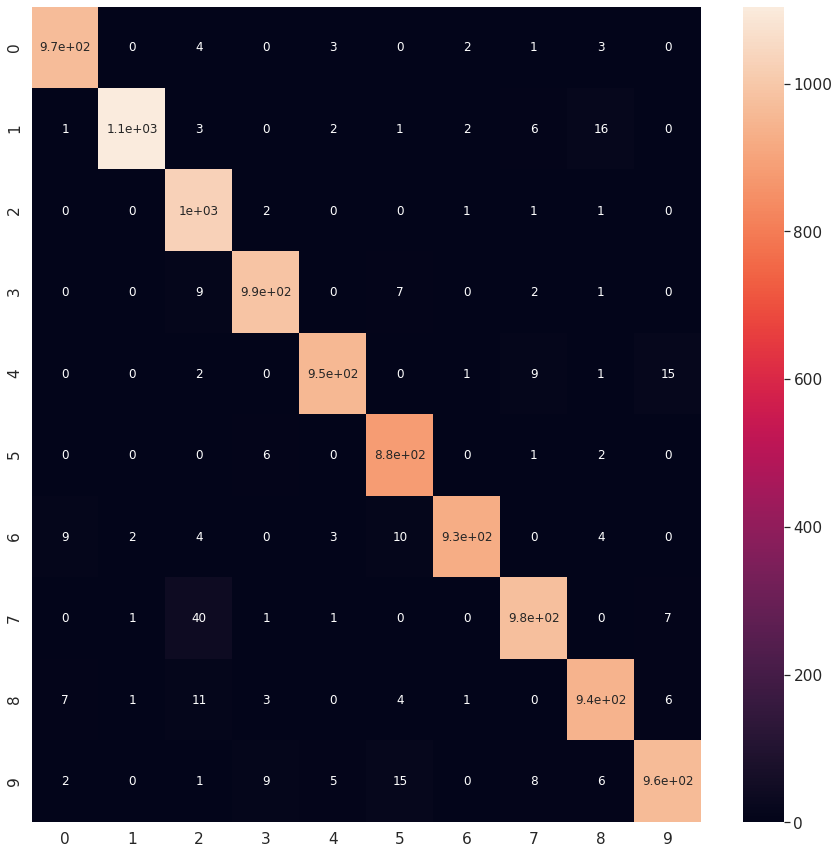

In [408]:
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd


df_cm = pd.DataFrame(cm, range(10),range(10))
#                     range(num_classes),
#                  range(num_classes))
#plt.figure(figsize = (10,7))
plt.figure(2,figsize = (15,15) )
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()


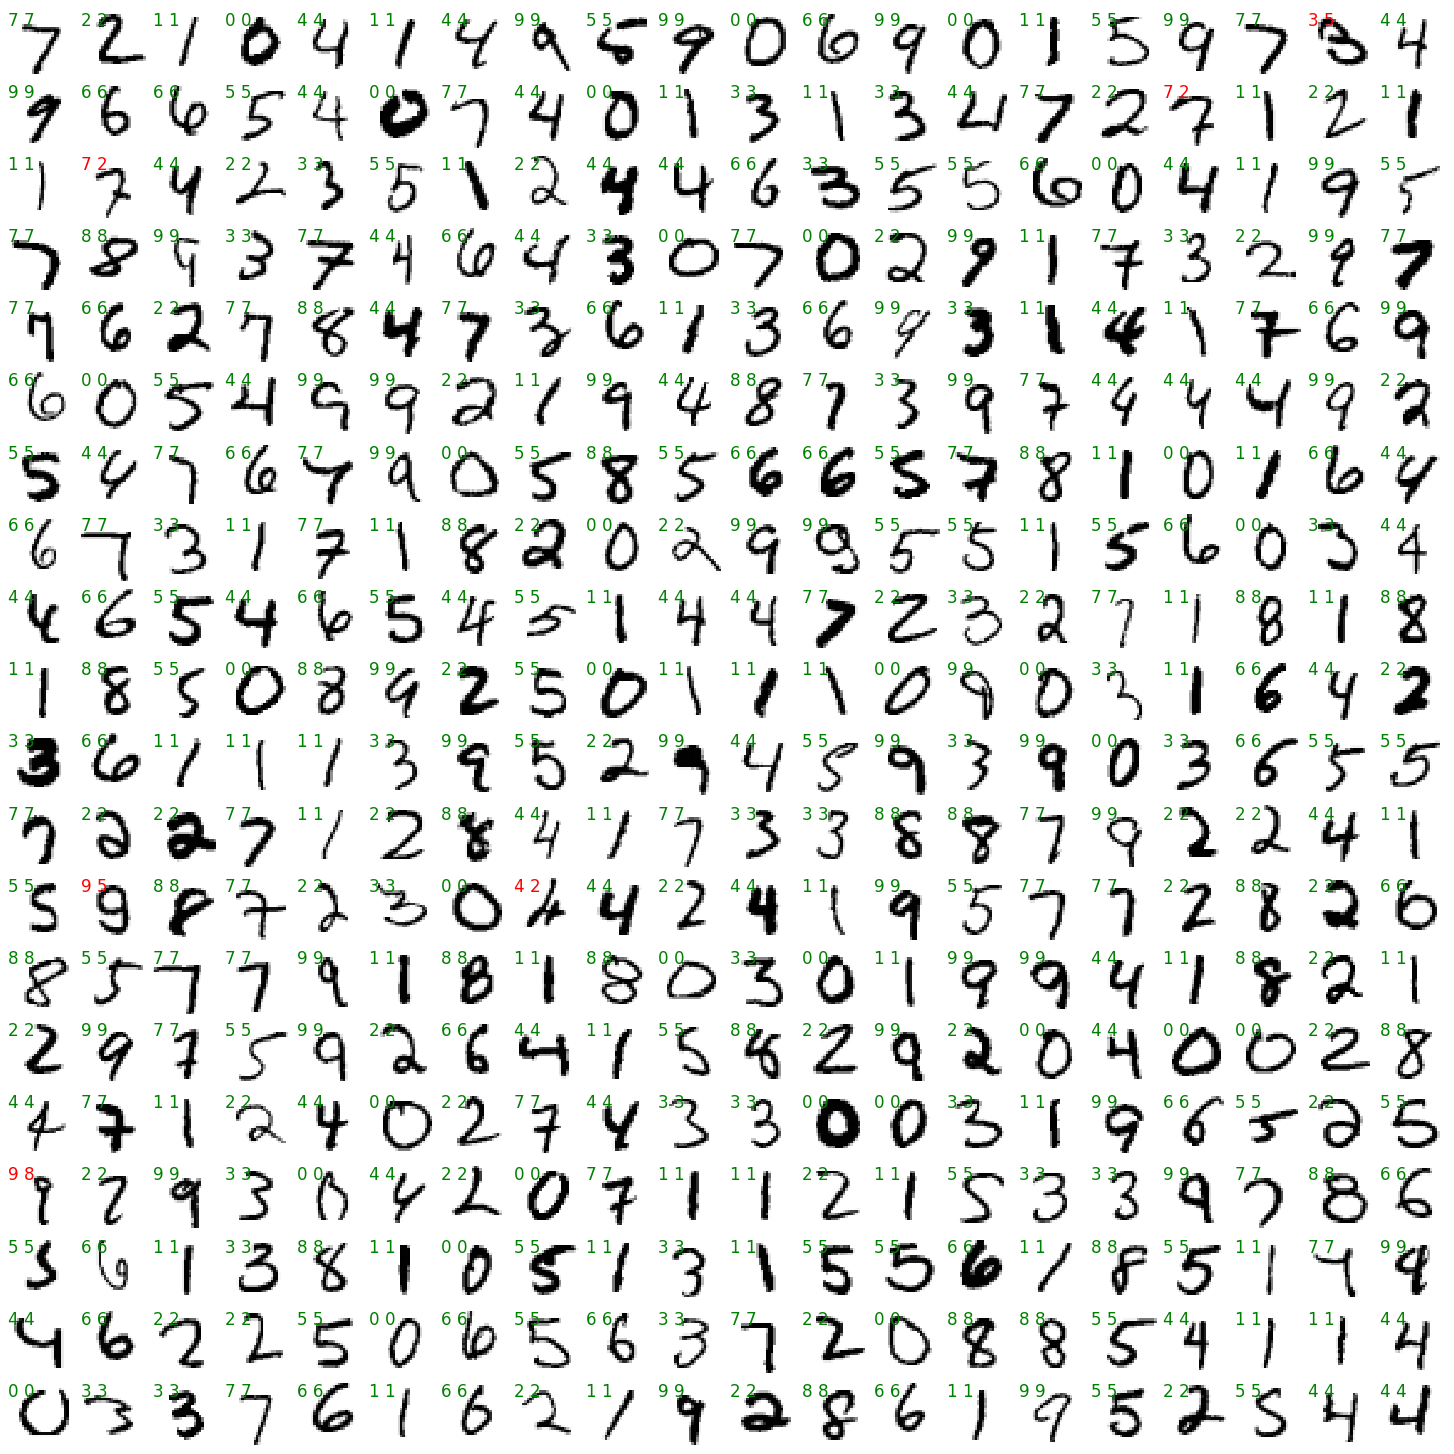

In [409]:
# use the model to predict the labels of the test data
predicted = model.predict(x_test)
expected = y_test0



# Plot the prediction
fig = plt.figure(figsize=(20, 20))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
for i in range(400):
    ax = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(img_rows, img_cols), cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    if np.argmax(predicted[i]) == expected[i]:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='green')
    else:
        ax.text(0, 7, str(expected[i])+" "+str(np.argmax(predicted[i])), color='red')

## Visualizing the Optimization History

In [410]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [411]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [412]:
from optuna.visualization import plot_contour

plot_contour(study)

## Visualizing Individual Parameters

In [413]:
from optuna.visualization import plot_slice

plot_slice(study)

## Visualizing Parameter Importances

In [414]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

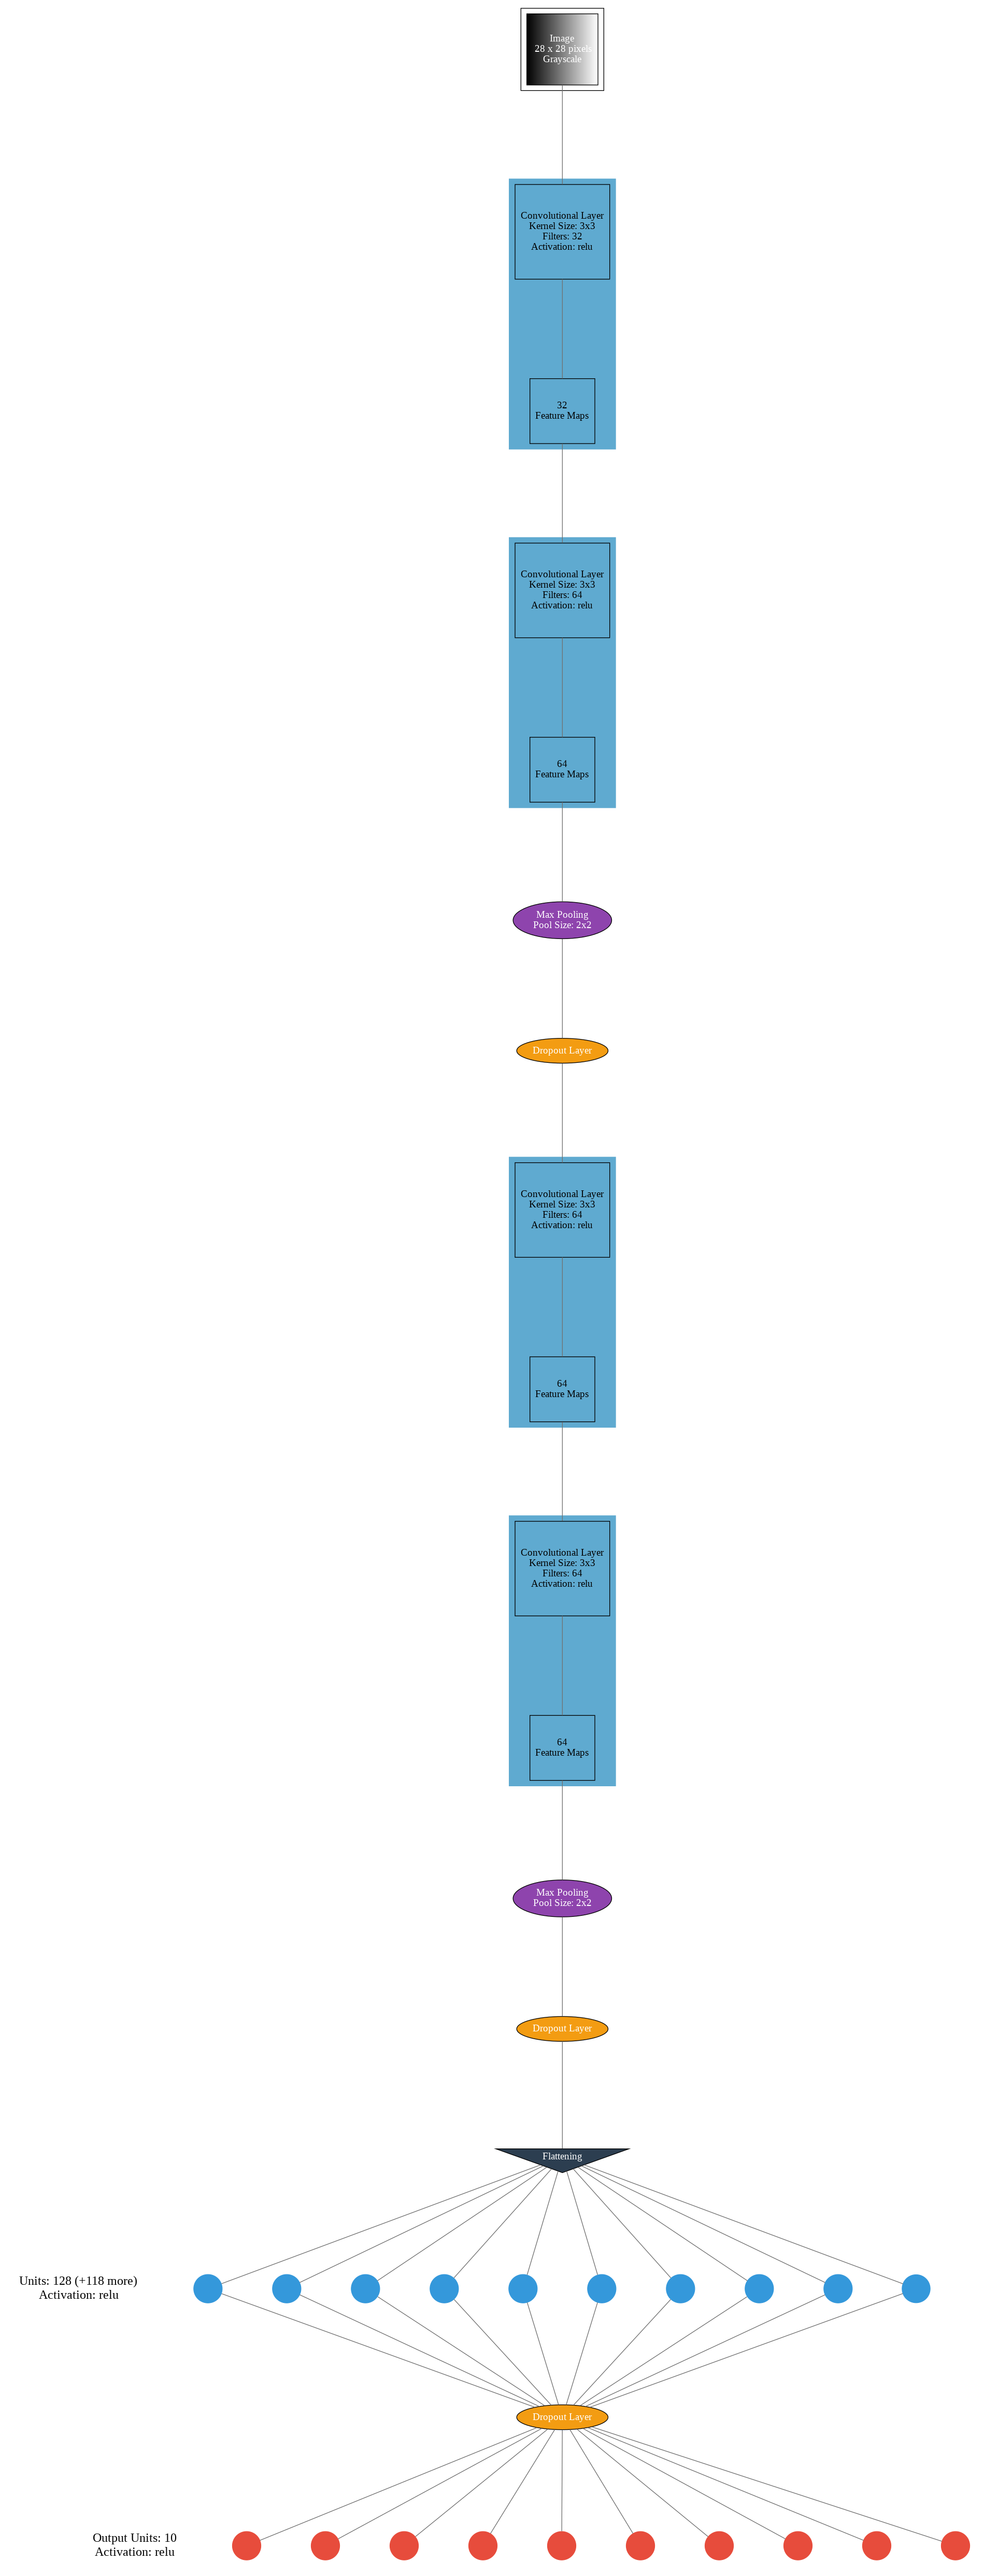

In [415]:
# Creates the graph.png file

! pip3 install keras-visualizer
from keras_visualizer import visualizer  

#create the graph.png image
visualizer(model=model, view=True, format='png', filename='graph')

#show the graph
import matplotlib.image as mpimg
img = mpimg.imread('graph.png')
#imgplot = plt.imshow(img,)
#plt.show()
Image('graph.png')